In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm import tqdm
import scipy.stats as stats
from scipy.signal import find_peaks, peak_widths
import itertools
import pandas as pd
# import pymc3 as pm
# import arviz as az
from datetime import datetime as dt
# import igraph as ig
# from statsmodels.stats.weightstats import ztest
# from rdkit import Chem
# from rdkit.Chem import Descriptors
import os
import datetime as dt

In [2]:
plt.style.use("default")
plt.rcParams.update({'font.size': 22})

palette = ["#e072b5",
"#69b15f",
"#737df6",
"#c79737",
"#b67ae4",
"#e57368",
"#799ddb"]

# Chemical properties figure

- MA changes
- MW change
- Novel fragments

## Set up MA section

In [40]:
#Load compound dates

fp = "/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Cpd_Date_Dict/"

cpd_dates_FULL = pickle.load(file=open(fp + "cpd_date_dict_FULL.p", "rb"))

In [3]:
#Load all assemblyGo results

MA_df = pd.read_csv("../Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo.csv'

In [42]:
print(MA_df)

         Unnamed: 0             label  MA_assemblyGo        time earliest_date
0                 0         SCHEMBL10           21.0  120.662484            -1
1                 1   SCHEMBL10000006           14.0  119.968879            -1
2                 2   SCHEMBL10000077           19.0  119.948782            -1
3                 3   SCHEMBL10000078           10.0   28.798358            -1
4                 4   SCHEMBL10000080            6.0    0.351274            -1
...             ...               ...            ...         ...           ...
3808354     3826713  2022-12_992_full           12.0  119.948646   2022-12_992
3808355     3826714  2022-12_993_full           33.0  119.991368   2022-12_993
3808356     3826715  2022-12_994_full           11.0    0.229392   2022-12_994
3808357     3826716  2022-12_995_full           25.0  119.656790   2022-12_995
3808358     3826717  2022-12_996_full           24.0  119.873772   2022-12_996

[3808359 rows x 5 columns]


Get earliest date for compounds

In [43]:
def get_earliest_date(ID, cpd_dates_FULL):
    if ID in cpd_dates_FULL:
        return cpd_dates_FULL[ID][0]
    else:
        if "new" in str(ID): 
            return ID.split("_")[0]
        elif "full" in str(ID):
            return ID.split("_")[0]
        else:
            return None

In [44]:
tqdm.pandas()

MA_df["earliest_date"] = MA_df["label"].progress_apply(get_earliest_date, args=(cpd_dates_FULL,))

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|█████████████████████████████| 3808359/3808359 [00:17<00:00, 216947.57it/s]


Convert dates to datetime objects

In [45]:
MA_df["earliest_date"] = pd.to_datetime(MA_df["earliest_date"])
MA_df["date_ordinal"] = MA_df["earliest_date"].map(dt.datetime.toordinal)

In [46]:
print(MA_df)

         Unnamed: 0             label  MA_assemblyGo        time  \
0                 0         SCHEMBL10           21.0  120.662484   
1                 1   SCHEMBL10000006           14.0  119.968879   
2                 2   SCHEMBL10000077           19.0  119.948782   
3                 3   SCHEMBL10000078           10.0   28.798358   
4                 4   SCHEMBL10000080            6.0    0.351274   
...             ...               ...            ...         ...   
3808354     3826713  2022-12_992_full           12.0  119.948646   
3808355     3826714  2022-12_993_full           33.0  119.991368   
3808356     3826715  2022-12_994_full           11.0    0.229392   
3808357     3826716  2022-12_995_full           25.0  119.656790   
3808358     3826717  2022-12_996_full           24.0  119.873772   

        earliest_date  date_ordinal  
0          1980-06-25        722991  
1          2007-02-06        732713  
2          2010-03-25        733856  
3          2010-03-25        73

Get MA values and statistics from each month

In [47]:
def get_month(label):
    """ Isolates the month from the given label

    Args:
        label (str): compound id in the form YYYY-MM_label

    Returns:
        str: YYYY-MM of a particular compound
    """
    return str(label)[:7]

In [48]:
tqdm.pandas()

MA_df["month"] = MA_df["earliest_date"].progress_apply(get_month)

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████| 3808359/3808359 [01:11<00:00, 52979.74it/s]


In [49]:
MA_df_months = MA_df.groupby("month")["MA_assemblyGo"].apply(list).reset_index(name="MAs")

print(MA_df_months)

       month                                                MAs
0    1965-02                                       [17.0, 18.0]
1    1965-05                                              [7.0]
2    1965-06                                              [9.0]
3    1966-03                                              [6.0]
4    1966-07                                              [6.0]
..       ...                                                ...
604  2022-09  [10.0, 31.0, 15.0, 25.0, 12.0, 29.0, 15.0, 16....
605  2022-10  [9.0, 33.0, 12.0, 16.0, 39.0, 38.0, 47.0, 50.0...
606  2022-11  [36.0, 36.0, 35.0, 14.0, 13.0, 11.0, 9.0, 32.0...
607  2022-12  [24.0, 29.0, 17.0, 26.0, 10.0, 24.0, 19.0, 14....
608      NaT                                              [nan]

[609 rows x 2 columns]


In [50]:
def get_mean(MAs):
    try:
        return np.mean(MAs)
    except:
        return 0
    
def get_std(MAs):
    try:
        return np.std(MAs)
    except:
        return 0
    
def get_IQR(MAs):
    try:
        return stats.iqr(MAs, interpolation="midpoint")
    except:
        return 0

In [51]:
tqdm.pandas() 

MA_df_months["avg"] = MA_df_months["MAs"].progress_apply(get_mean)
MA_df_months["std"] = MA_df_months["MAs"].progress_apply(get_std)
MA_df_months["iqr"] = MA_df_months["MAs"].progress_apply(get_IQR)

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|███████████████████████████████████████| 609/609 [00:00<00:00, 1004.84it/s]


In [52]:
MA_df_months["date"] = pd.to_datetime(MA_df_months["month"])
MA_df_months["date_ordinal"] = MA_df_months["date"].map(dt.datetime.toordinal)

In [18]:
print(MA_df_months)

       month                                                MAs        avg  \
0    1965-02                                       [17.0, 18.0]  17.500000   
1    1965-05                                              [7.0]   7.000000   
2    1965-06                                              [9.0]   9.000000   
3    1966-03                                              [6.0]   6.000000   
4    1966-07                                              [6.0]   6.000000   
..       ...                                                ...        ...   
604  2022-09  [10.0, 31.0, 15.0, 25.0, 12.0, 29.0, 15.0, 16....  20.306606   
605  2022-10  [9.0, 33.0, 12.0, 16.0, 39.0, 38.0, 47.0, 50.0...  19.876079   
606  2022-11  [36.0, 36.0, 35.0, 14.0, 13.0, 11.0, 9.0, 32.0...  21.724103   
607  2022-12  [24.0, 29.0, 17.0, 26.0, 10.0, 24.0, 19.0, 14....  21.722990   
608      NaT                                              [nan]        NaN   

           std   iqr       date  date_ordinal  
0     0.500000 

(2191.0, 19723.0)

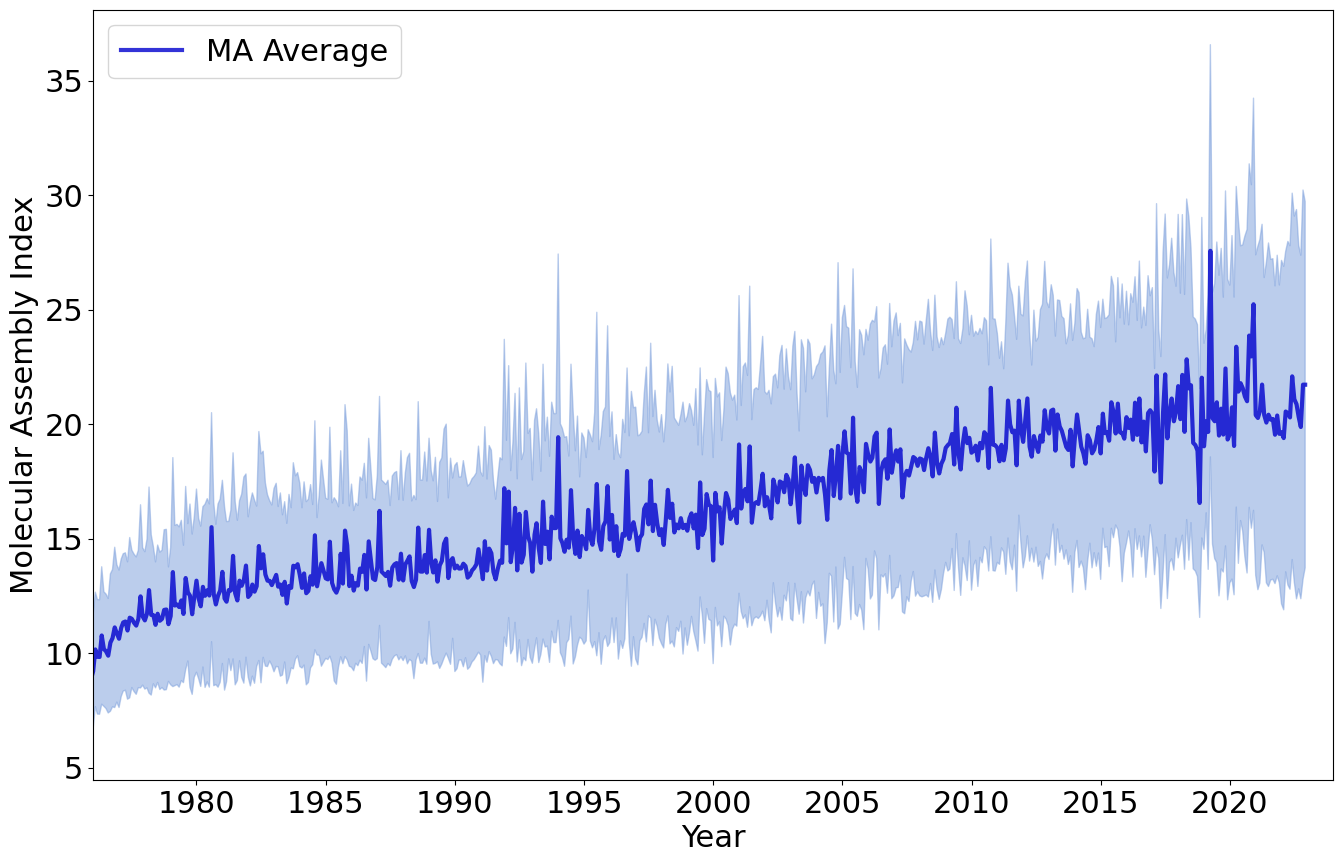

In [53]:
#Assembly values with standard deviation

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(MA_df_months["date"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="MA Average")

plt.fill_between(MA_df_months["date"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color=palette[6])

plt.legend(loc="upper left", prop={"size":"22"})
plt.xlabel("Year")
plt.ylabel("Molecular Assembly Index")
plt.xlim(dt.date(1976,1,1), dt.date(2024,1,1))

## Set up molecular weight figure

In [57]:
## Read molecular weight df (obtained from full surechembl database)
filtered_sc_df = pd.read_csv("../Data/molecular_weight_chemblCpds.csv")

In [58]:
#Merge with MA results to link dates with MW

mw_df = pd.merge(left=MA_df, right=filtered_sc_df, left_on="label", right_on="SureChEMBL_ID", how="outer")

print(mw_df)

         Unnamed: 0_x            label  MA_assemblyGo        time  \
0                 0.0        SCHEMBL10           21.0  120.662484   
1                 1.0  SCHEMBL10000006           14.0  119.968879   
2                 2.0  SCHEMBL10000077           19.0  119.948782   
3                 3.0  SCHEMBL10000078           10.0   28.798358   
4                 4.0  SCHEMBL10000080            6.0    0.351274   
...               ...              ...            ...         ...   
4433220           NaN              NaN            NaN         NaN   
4433221           NaN              NaN            NaN         NaN   
4433222           NaN              NaN            NaN         NaN   
4433223           NaN              NaN            NaN         NaN   
4433224           NaN              NaN            NaN         NaN   

        earliest_date  date_ordinal    month  Unnamed: 0_y    SureChEMBL_ID  \
0          1980-06-25      722991.0  1980-06           2.0        SCHEMBL10   
1          20

In [52]:
mw_df = pd.read_csv("../Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo_MW.csv")

In [59]:
print(mw_df)

         Unnamed: 0_x            label  MA_assemblyGo        time  \
0                 0.0        SCHEMBL10           21.0  120.662484   
1                 1.0  SCHEMBL10000006           14.0  119.968879   
2                 2.0  SCHEMBL10000077           19.0  119.948782   
3                 3.0  SCHEMBL10000078           10.0   28.798358   
4                 4.0  SCHEMBL10000080            6.0    0.351274   
...               ...              ...            ...         ...   
4433220           NaN              NaN            NaN         NaN   
4433221           NaN              NaN            NaN         NaN   
4433222           NaN              NaN            NaN         NaN   
4433223           NaN              NaN            NaN         NaN   
4433224           NaN              NaN            NaN         NaN   

        earliest_date  date_ordinal    month  Unnamed: 0_y    SureChEMBL_ID  \
0          1980-06-25      722991.0  1980-06           2.0        SCHEMBL10   
1          20

Statistics over each month

In [60]:
MW_df_months = mw_df.groupby("month")["mw"].apply(list).reset_index(name="MWs")

tqdm.pandas() 

MW_df_months["avg"] = MW_df_months["MWs"].progress_apply(get_mean)
MW_df_months["std"] = MW_df_months["MWs"].progress_apply(get_std)
MW_df_months["iqr"] = MW_df_months["MWs"].progress_apply(get_IQR)

#Change dates to ordinals
MW_df_months["date"] = pd.to_datetime(MW_df_months["month"])
MW_df_months["date_ordinal"] = MW_df_months["date"].map(dt.datetime.toordinal)

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████| 609/609 [00:00<00:00, 728.36it/s]


In [61]:
print(MW_df_months)

       month                                                MWs         avg  \
0    1965-02             [416.3290452679999, 416.3290452679999]  416.329045   
1    1965-05                                    [144.068748256]  144.068748   
2    1965-06                                    [144.068748256]  144.068748   
3    1966-03                                    [199.045570288]  199.045570   
4    1966-07                                    [117.057849224]  117.057849   
..       ...                                                ...         ...   
604  2022-09  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         NaN   
605  2022-10  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         NaN   
606  2022-11  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         NaN   
607  2022-12  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         NaN   
608      NaT                                              [nan]         NaN   

     std  iqr       date  date_ordinal  
0    0.0  

Text(0, 0.5, 'Molecular Weight (Daltons)')

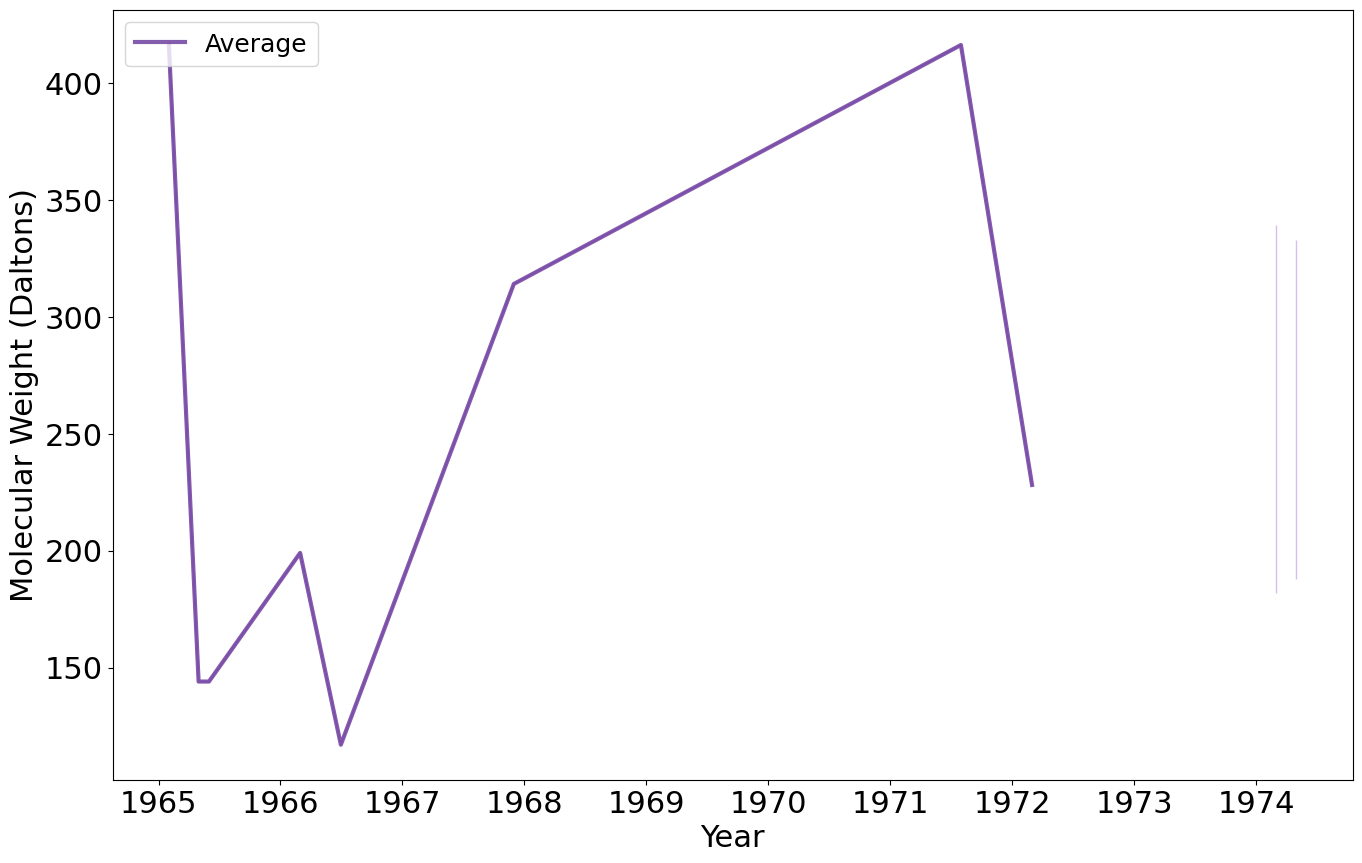

In [62]:
#Assembly values with IQR

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(MW_df_months["date"], MW_df_months["avg"], color="rebeccapurple",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color=palette[4],
                label="")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

Alternative graphing - not sure what's going on with missing values above

In [54]:
mw_df = pd.read_csv("../Data/AssemblyValues/ALLCPDS_mw.csv")
print(mw_df)

         Unnamed: 0                                              Inchi  \
0                 0  InChI=1S/C20H28N2O5.C4H4O4/c1-3-27-20(26)16(12...   
1                 1  InChI=1S/C21H21N3O/c1-5-24(6-2)19-10-7-17(8-11...   
2                 2  InChI=1S/C30H34F2O16/c1-7-21(34)42-13-28(12-41...   
3                 3  InChI=1S/C12H10F8O6/c1-3-7(21)23-5-9(13,14)25-...   
4                 4  InChI=1S/C9H10F2O4/c1-3-7(12)14-5-9(10,11)6-15...   
...             ...                                                ...   
3136863     3136863  InChI=1S/C57H35NO2/c1-2-15-41-36(13-1)14-11-23...   
3136864     3136864  InChI=1S/C44H27NO/c1-3-13-32-28(11-1)26-41(37-...   
3136865     3136865  InChI=1S/C24H27N5O/c1-3-15-12-18(30)5-7-19(15)...   
3136866     3136866  InChI=1S/C30H29N5O/c1-2-21-16-24(36)9-11-25(21...   
3136867     3136867  InChI=1S/C24H25N5O2/c1-2-15-11-18(31)4-6-19(15...   

           month          mw  
0        1980-06  492.210781  
1        2007-02  331.168462  
2        2010-03  

In [55]:
MW_df_months = mw_df.groupby("month")["mw"].apply(list).reset_index(name="MWs")

tqdm.pandas() 

MW_df_months["avg"] = MW_df_months["MWs"].progress_apply(get_mean)
MW_df_months["std"] = MW_df_months["MWs"].progress_apply(get_std)
MW_df_months["iqr"] = MW_df_months["MWs"].progress_apply(get_IQR)

#Change dates to ordinals
MW_df_months["date"] = pd.to_datetime(MW_df_months["month"])
MW_df_months["date_ordinal"] = MW_df_months["date"].map(dt.datetime.toordinal)

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|███████████████████████████████████████| 609/609 [00:00<00:00, 1104.82it/s]


In [56]:
print(MW_df_months)

       month                                                MWs         avg  \
0    1965-02             [416.3290452679999, 416.3290452679999]  416.329045   
1    1965-05                                    [144.068748256]  144.068748   
2    1965-06                                    [144.068748256]  144.068748   
3    1966-03                                    [199.045570288]  199.045570   
4    1966-07                                    [117.057849224]  117.057849   
..       ...                                                ...         ...   
604  2022-09  [194.968361292, 136.052429496, 345.11471246799...  442.823622   
605  2022-10  [331.113666912, 412.29774513999985, 279.175377...  433.305557   
606  2022-11  [212.08372962400003, 217.95924822400002, 324.2...  486.383234   
607  2022-12  [181.073893212, 189.10010796, 147.068413908, 4...  481.003080   
608      NaT  [-1.0, 204.08987762400002, 613.769650768, 160....  289.900426   

            std         iqr       date  date_ordina

(2191.0, 19723.0)

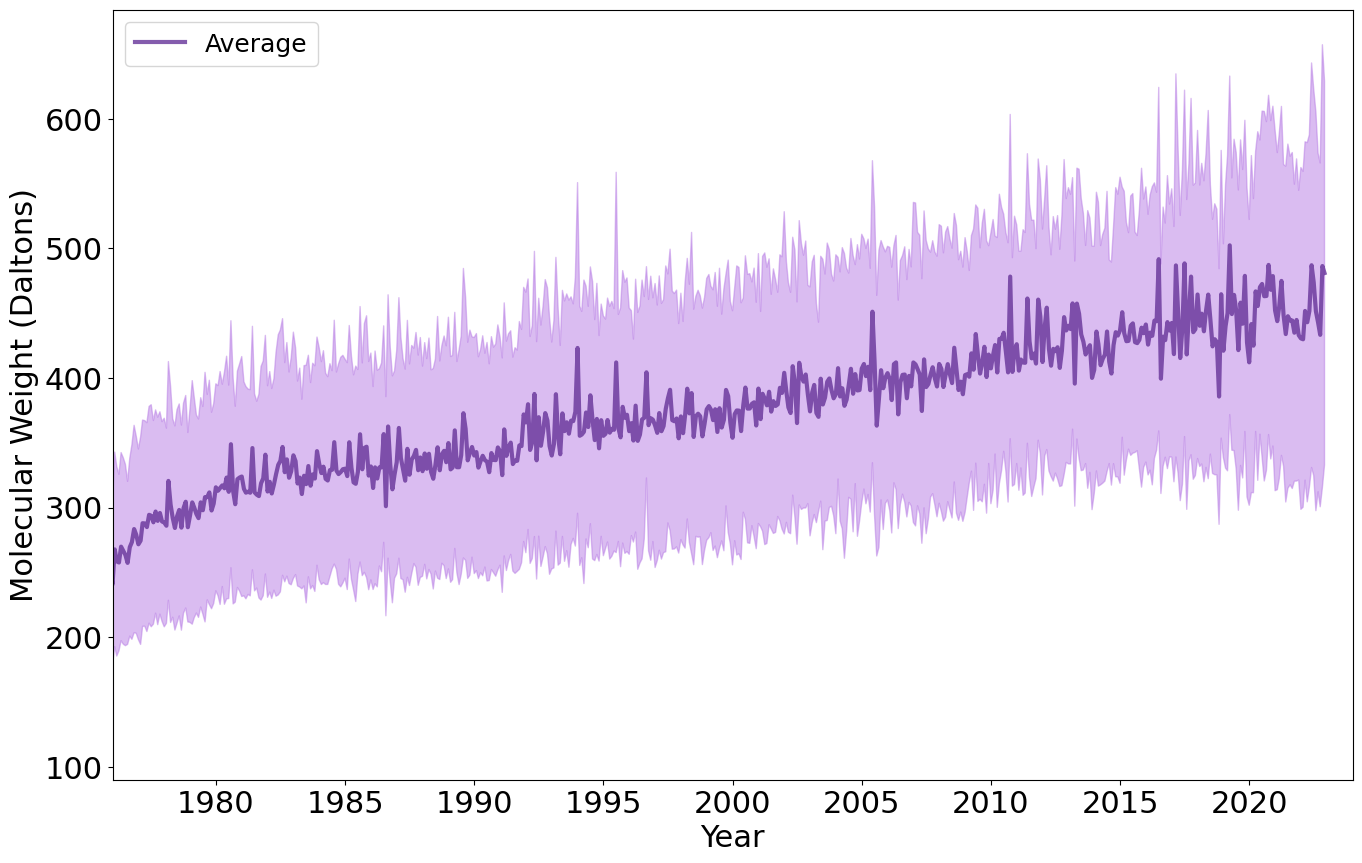

In [57]:
#MW with IQR

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(MW_df_months["date"], MW_df_months["avg"], color="rebeccapurple",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color=palette[4],
                label="")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")
plt.xlim(dt.date(1976,1,1), dt.date(2024,1,1))

## Bonds

Create figure on the number of bonds over time (have this be black?)

In [58]:
bonds_df = pd.read_csv("../Data/AssemblyValues/ALLCPDS_bonds.csv")
print(bonds_df)

         Unnamed: 0                                              Inchi  \
0                 0  InChI=1S/C20H28N2O5.C4H4O4/c1-3-27-20(26)16(12...   
1                 1  InChI=1S/C21H21N3O/c1-5-24(6-2)19-10-7-17(8-11...   
2                 2  InChI=1S/C30H34F2O16/c1-7-21(34)42-13-28(12-41...   
3                 3  InChI=1S/C12H10F8O6/c1-3-7(21)23-5-9(13,14)25-...   
4                 4  InChI=1S/C9H10F2O4/c1-3-7(12)14-5-9(10,11)6-15...   
...             ...                                                ...   
3136863     3136863  InChI=1S/C57H35NO2/c1-2-15-41-36(13-1)14-11-23...   
3136864     3136864  InChI=1S/C44H27NO/c1-3-13-32-28(11-1)26-41(37-...   
3136865     3136865  InChI=1S/C24H27N5O/c1-3-15-12-18(30)5-7-19(15)...   
3136866     3136866  InChI=1S/C30H29N5O/c1-2-21-16-24(36)9-11-25(21...   
3136867     3136867  InChI=1S/C24H25N5O2/c1-2-15-11-18(31)4-6-19(15...   

           month  bonds  
0        1980-06     35  
1        2007-02     26  
2        2010-03     47  
3      

In [59]:
bonds_df_months = bonds_df.groupby("month")["bonds"].apply(list).reset_index(name="bonds")

tqdm.pandas() 

bonds_df_months["avg"] = bonds_df_months["bonds"].progress_apply(get_mean)
bonds_df_months["std"] = bonds_df_months["bonds"].progress_apply(get_std)
bonds_df_months["iqr"] = bonds_df_months["bonds"].progress_apply(get_IQR)

#Change dates to ordinals
bonds_df_months["date"] = pd.to_datetime(bonds_df_months["month"])
bonds_df_months["date_ordinal"] = bonds_df_months["date"].map(dt.datetime.toordinal)

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████| 609/609 [00:00<00:00, 857.66it/s]


(2191.0, 19723.0)

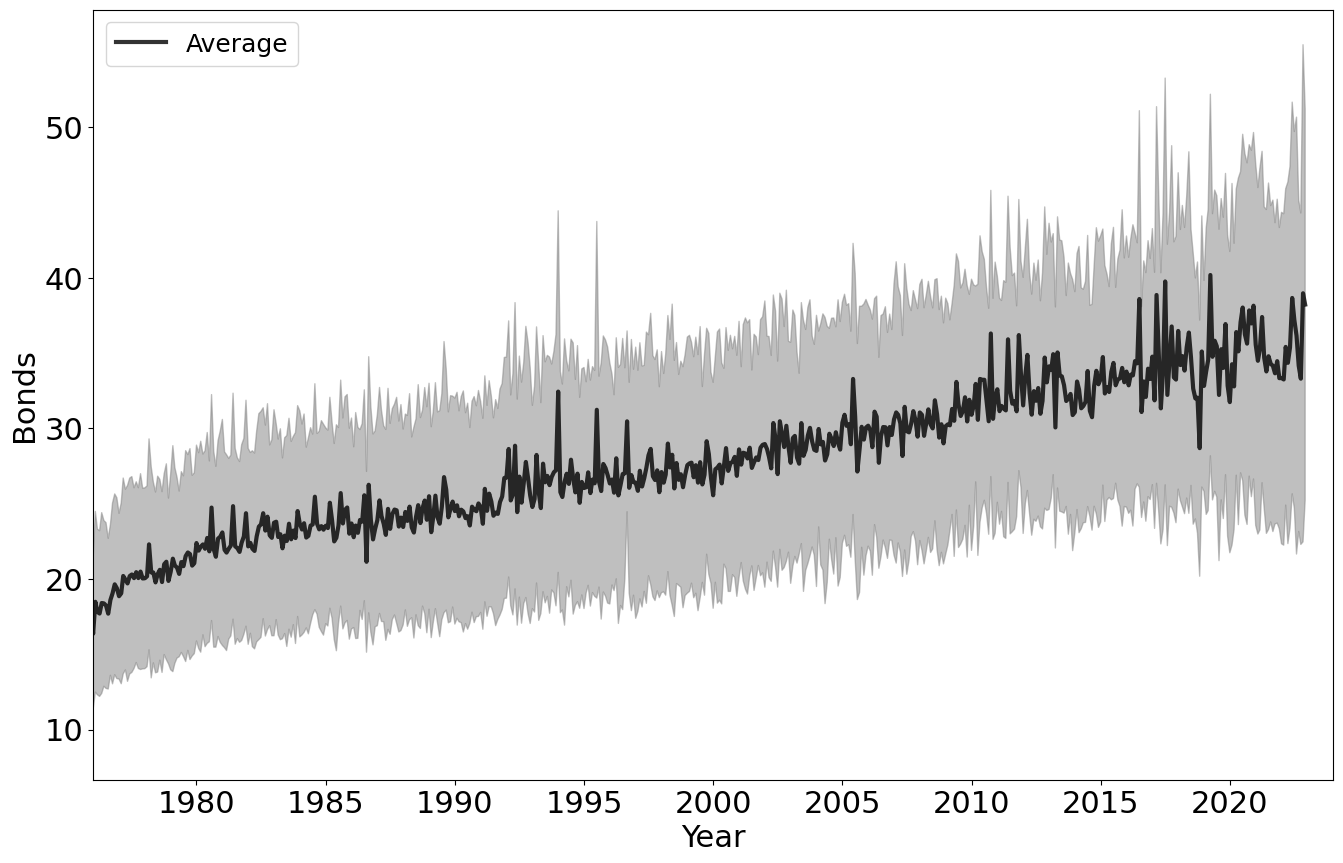

In [60]:
#Bonds with IQR

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(bonds_df_months["date"], bonds_df_months["avg"], color="k",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(bonds_df_months["date"], bonds_df_months["avg"] + bonds_df_months["iqr"]/2, 
                bonds_df_months["avg"] - bonds_df_months["iqr"]/2, alpha=0.5, color="grey",
                label="")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Bonds")
plt.xlim(dt.date(1976,1,1), dt.date(2024,1,1))

## Fragment figure

In [61]:
new_frag_count = pickle.load(file=open("../Data/AssemblyValues/Fragments/author_newFragCount.p", "rb"))

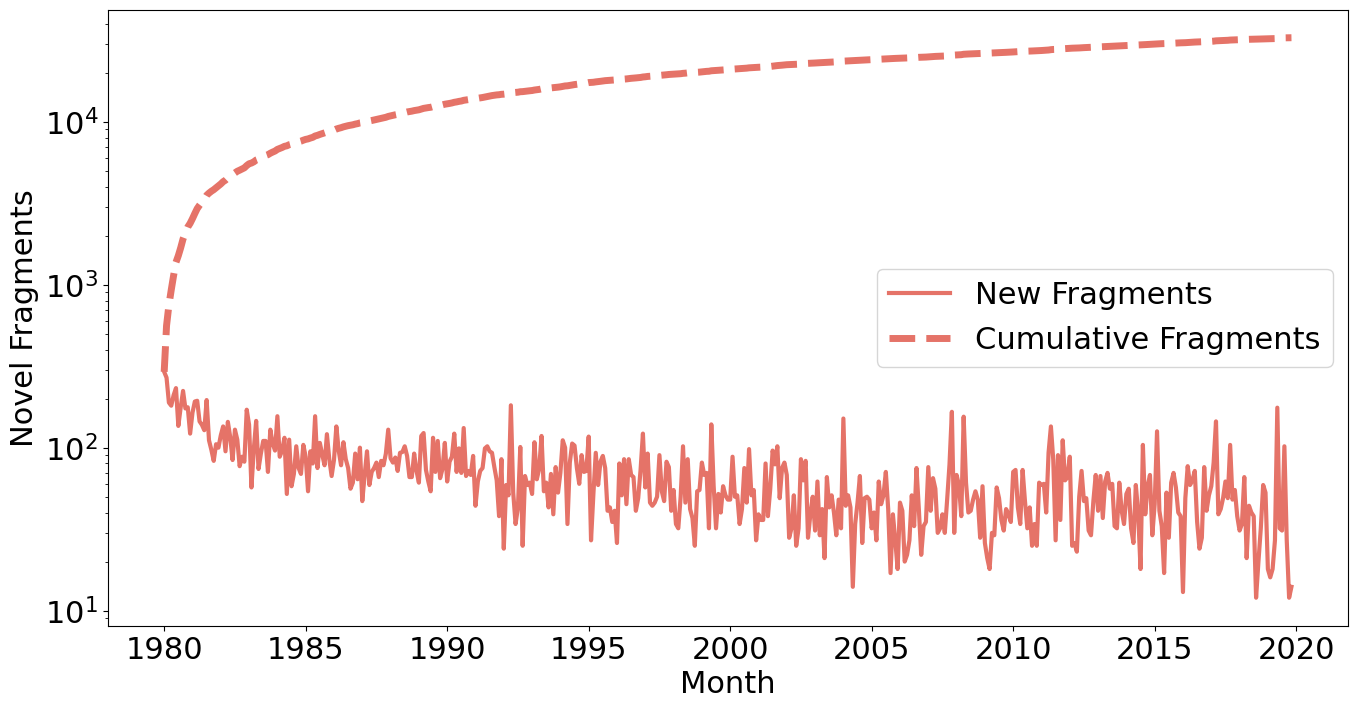

In [62]:
plt.figure(figsize=(16,8))


plt.plot(list(np.arange(1980, 2020, 1/12))[:-1], new_frag_count, 
         linewidth=3, color=palette[5], label="New Fragments")

plt.plot(list(np.arange(1980, 2020, 1/12))[:-1], np.cumsum(new_frag_count), 
         linewidth=5, color=palette[5], linestyle="--", label="Cumulative Fragments")

plt.yscale("log")

plt.xlabel("Month")
plt.ylabel("Novel Fragments")

plt.legend()

plt.show()

## Full Figure

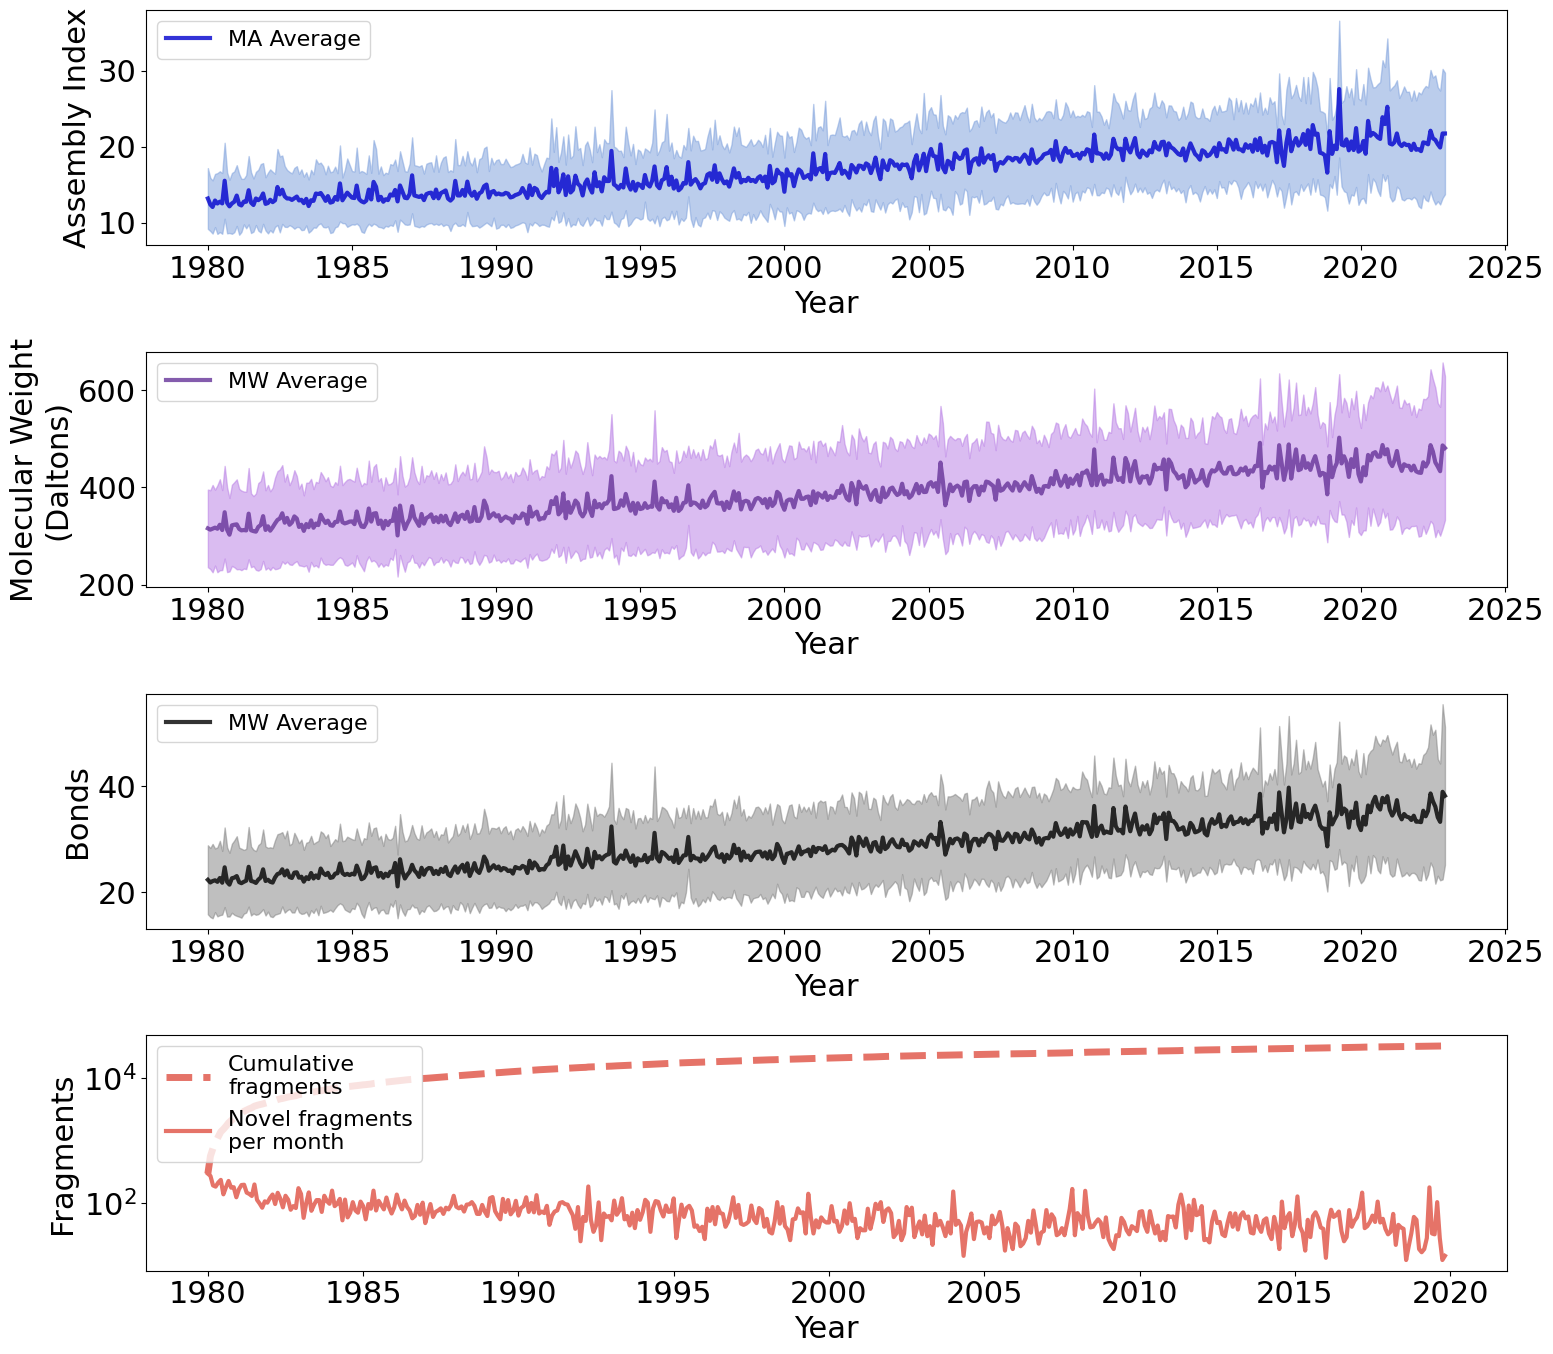

In [64]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(4,3)

fig = plt.figure(figsize=(16,14))

## MA Figure
ax1 = fig.add_subplot(gs[0,:])

MA_df_months_filtered = MA_df_months[MA_df_months["date"] >= "1980"]
ax1.plot(MA_df_months_filtered["date"], MA_df_months_filtered["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="MA Average")

ax1.fill_between(MA_df_months_filtered["date"], MA_df_months_filtered["avg"] + MA_df_months_filtered["iqr"]/2, 
                MA_df_months_filtered["avg"] - MA_df_months_filtered["iqr"]/2, alpha=0.5, color=palette[6],)

ax1.legend(loc="upper left", prop={"size":"16"})
ax1.set_xlabel("Year")
ax1.set_ylabel("Assembly Index")


## MW Figure
ax2 = fig.add_subplot(gs[1,:])

MW_df_months_filtered = MW_df_months[MW_df_months["date"] >= "1980"]
ax2.plot(MW_df_months_filtered["date"], MW_df_months_filtered["avg"], color="rebeccapurple",
            linewidth=3, markersize=10, alpha=0.8, label="MW Average")

ax2.fill_between(MW_df_months_filtered["date"], MW_df_months_filtered["avg"] + MW_df_months_filtered["iqr"]/2, 
                MW_df_months_filtered["avg"] - MW_df_months_filtered["iqr"]/2, alpha=0.5, color=palette[4])

ax2.legend(loc="upper left", prop={"size":"16"})
ax2.set_xlabel("Year")
ax2.set_ylabel("Molecular Weight\n(Daltons)")

## Bonds figure
ax2 = fig.add_subplot(gs[2,:])

bonds_df_months_filtered = bonds_df_months[bonds_df_months["date"] >= "1980"]
ax2.plot(bonds_df_months_filtered["date"], bonds_df_months_filtered["avg"], color="k",
            linewidth=3, markersize=10, alpha=0.8, label="MW Average")

ax2.fill_between(bonds_df_months_filtered["date"], bonds_df_months_filtered["avg"] + bonds_df_months_filtered["iqr"]/2, 
                bonds_df_months_filtered["avg"] - bonds_df_months_filtered["iqr"]/2, alpha=0.5, color="grey")

ax2.legend(loc="upper left", prop={"size":"16"})
ax2.set_xlabel("Year")
ax2.set_ylabel("Bonds")

## Fragment figure
ax3 = fig.add_subplot(gs[3,:])

ax3.plot(list(np.arange(1980, 2020, 1/12))[:-1], np.cumsum(new_frag_count), 
         linewidth=5, color=palette[5], linestyle="--", label="Cumulative\nfragments")

ax3.plot(list(np.arange(1980, 2020, 1/12))[:-1], new_frag_count, 
         linewidth=3, color=palette[5], label="Novel fragments\nper month")



ax3.set_yscale("log")

ax3.legend(loc="upper left", prop={"size":"16"})
ax3.set_xlabel("Year")
ax3.set_ylabel("Fragments")
#ax3.set_ylim(1980, 2022)

plt.tight_layout()


## Statistics over MA & MW

Linear regressions & basic stats over both time-series data

In [32]:
import scipy.stats as stats
import statsmodels.api as sm

In [36]:
#Basic linear regression & statistics over MA distribution

MA_df_months_filtered = MA_df_months[MA_df_months["date"] >= "1976"]

MA_slope, MA_intercept = np.polyfit(MA_df_months_filtered["date_ordinal"], MA_df_months_filtered["avg"], 1)

##Calculate Spearman correlation (not assuming normality)
MA_spearman_corr = stats.spearmanr(MA_df_months_filtered["date_ordinal"], MA_df_months_filtered["avg"])

print("Slope:", MA_slope) 
print("Intercept:", MA_intercept)
print(MA_spearman_corr)

Slope: 0.0005972771059059286
Intercept: -419.577953931307
SpearmanrResult(correlation=0.9563023625017686, pvalue=2.560989662027012e-302)


In [27]:
#Basic linear regression & statistics over MW distribution

MW_slope, MW_intercept = np.polyfit(MW_df_months["date_ordinal"], MW_df_months["avg"], 1)

##Calculate Spearman correlation (not assuming normality)
MW_spearman_corr = stats.spearmanr(MW_df_months["date_ordinal"], MW_df_months["avg"])

print("Slope:", MW_slope) 
print("Intercept:", MW_intercept)
print(MW_spearman_corr)

Slope: 0.00044578584489254484
Intercept: 42.552349145817594
SpearmanrResult(correlation=0.9577070718465239, pvalue=0.0)


/var/folders/bx/hv1n_1yj6qv0z_5d3nqlhr5c0000gw/T/ipykernel_80526/501097572.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)


[Text(720000.0, 0, '1972'),
 Text(722000.0, 0, '1977'),
 Text(724000.0, 0, '1983'),
 Text(726000.0, 0, '1988'),
 Text(728000.0, 0, '1994'),
 Text(730000.0, 0, '1999'),
 Text(732000.0, 0, '2005'),
 Text(734000.0, 0, '2010'),
 Text(736000.0, 0, '2016'),
 Text(738000.0, 0, '2021'),
 Text(740000.0, 0, '2027')]

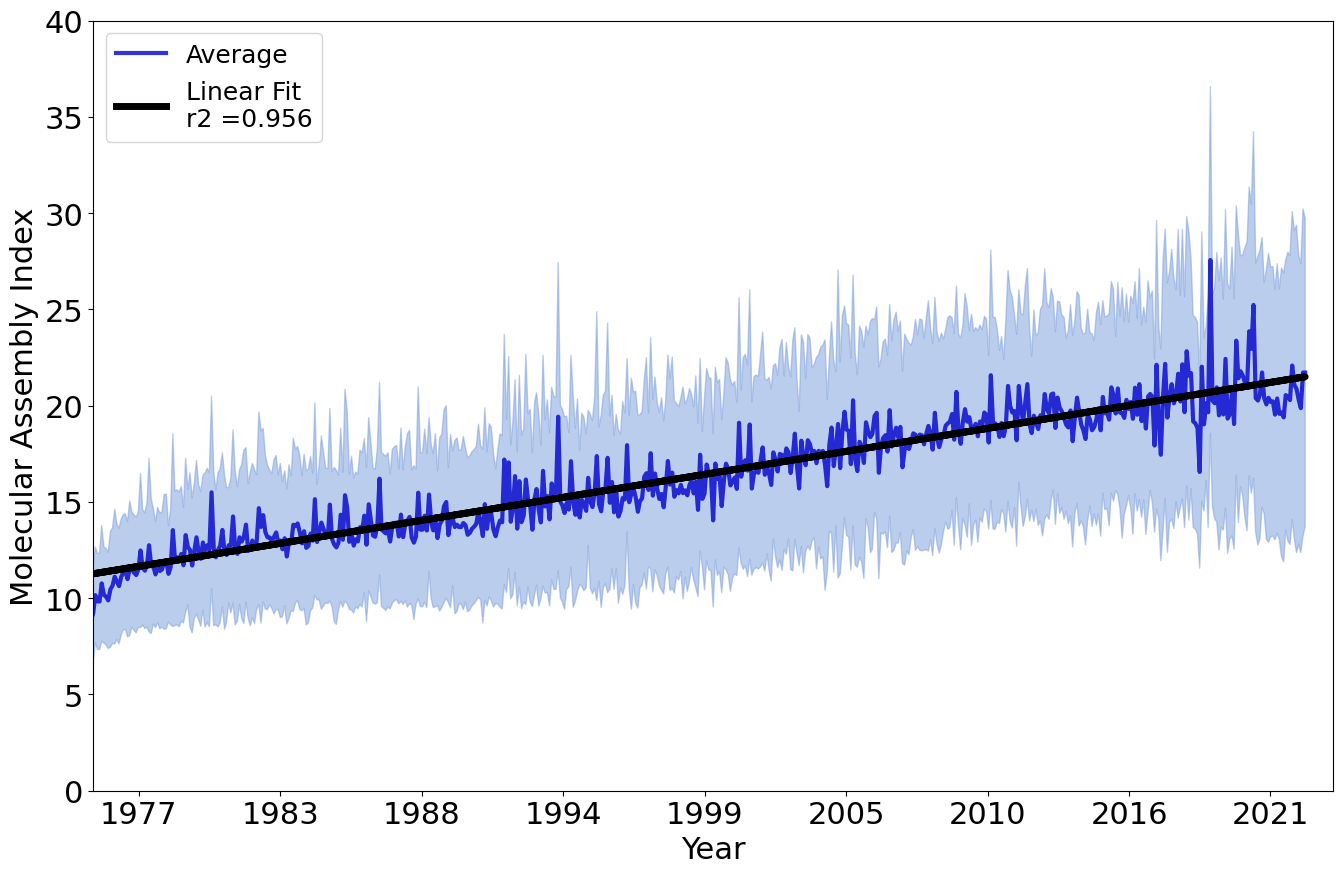

In [45]:
#MW graphing with linear regression

import matplotlib.ticker as plticker


fig, ax = plt.subplots(figsize=(16,10))

plt.plot(MA_df_months["date_ordinal"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MA_df_months["date_ordinal"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color=palette[6],
                label="")

## Linear regression
plt.plot(MA_df_months["date_ordinal"], MA_slope * MA_df_months["date_ordinal"] + MA_intercept, color="k", linewidth=5,
        label="Linear Fit\nr2 =" + str(round(MA_spearman_corr[0], 3)))

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Assembly Index")
plt.xlim(dt.date.toordinal(dt.date(1976, 1, 1)), dt.date.toordinal(dt.date(2024, 1, 1)))
plt.ylim(0,40)

a=ax.get_xticks().tolist()
xticks = [dt.datetime.fromordinal(int(x)).year for x in a]
ax.set_xticklabels(xticks)

(2191.0, 19723.0)

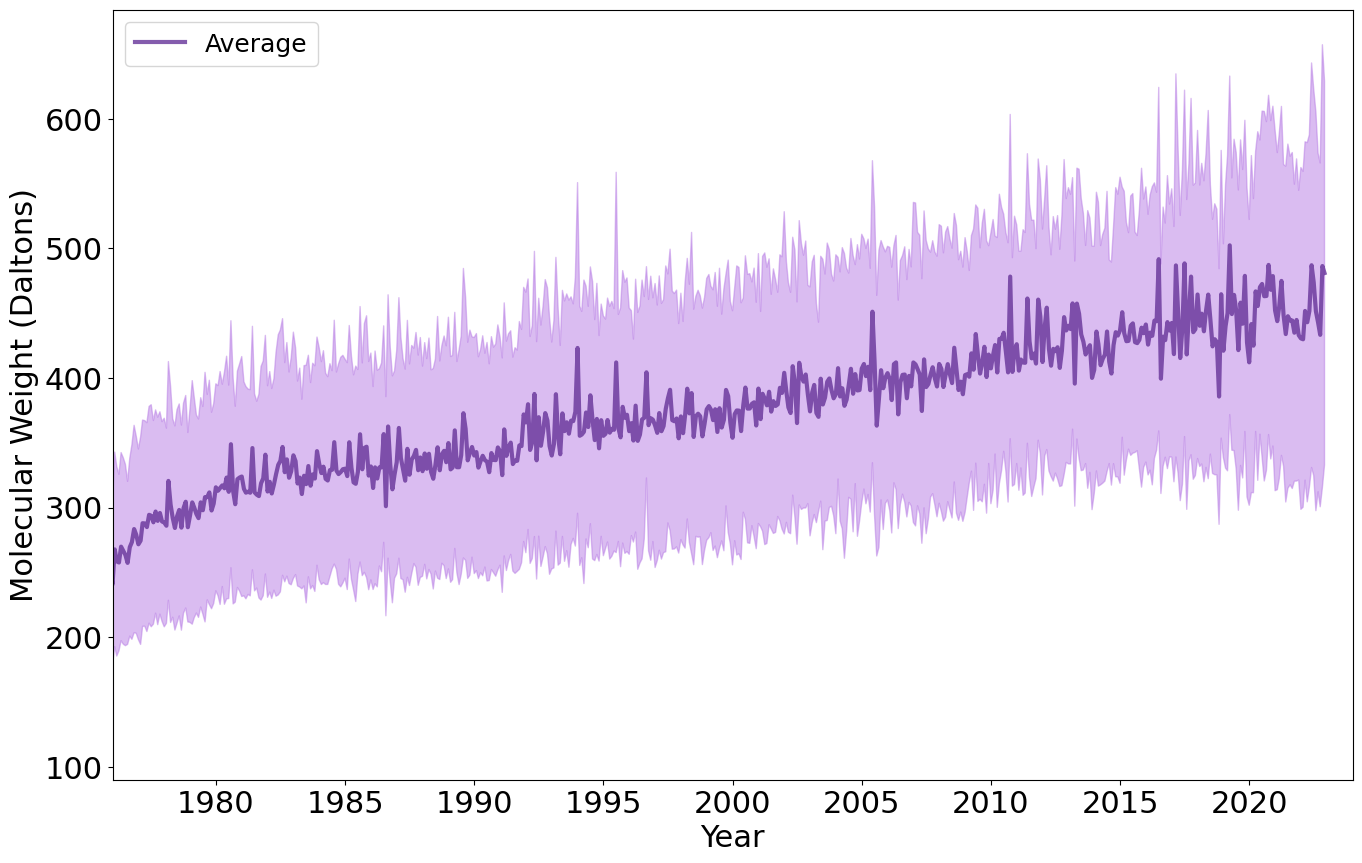

In [33]:
#MW graphing with linear regression

import matplotlib.ticker as plticker

plt.figure(figsize=(16,10))

plt.plot(MW_df_months["date"], MW_df_months["avg"], color="rebeccapurple",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color=palette[4],
                label="")

# # Linear regression
# plt.plot(MW_df_months["date_ordinal"], MW_slope * MW_df_months["date_ordinal"] + MW_intercept, color="k", linewidth=5,
#         label="Linear Fit\nr2 =" + str(round(MW_spearman_corr[0], 3)))

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")
plt.xlim(dt.date(1976,1,1), dt.date(2024,1,1))




## Values of MA/MW at specific dates

For right now, looking for:
- Average MA & MW at Jan 1976 and Dec 2020

In [75]:
print(MA_df_months[MA_df_months["month"] == "1976-01"])
print()
print(MA_df_months[MA_df_months["month"] == "2020-12"])

      month                                                MAs       avg  \
44  1976-01  [8.0, 16.0, 8.0, 8.0, 8.0, 9.0, 5.0, 9.0, 8.0,...  8.857341   

         std  iqr       date  date_ordinal  
44  4.343837  4.0 1976-01-01        721354  

       month                                                MAs        avg  \
583  2020-12  [9.0, 46.0, 14.0, 46.0, 7.0, 47.0, 41.0, 41.0,...  23.890889   

          std   iqr       date  date_ordinal  
583  11.05373  17.0 2020-12-01        737760  


In [76]:
print(MW_df_months[MW_df_months["month"] == "1976-01"])
print()
print(MW_df_months[MW_df_months["month"] == "2020-12"])

      month                                                MWs         avg  \
44  1976-01  [260.18100113599996, 338.1338676759998, 259.14...  231.060836   

           std         iqr       date  date_ordinal  
44  109.923037  112.020308 1976-01-01        721354  

       month                                                MWs         avg  \
583  2020-12  [240.099773612, 909.4097494760001, 297.0848518...  504.430762   

            std        iqr       date  date_ordinal  
583  204.926171  276.87106 2020-12-01        737760  


## Statistics over fragments

Test:
- Linearity of fragments (when does it become linear)
- Others?

In [ ]:
## Test for when r2 of linear regression doesn't change...
rsquares = []

for i in range(len(new_frag_count)):
    #